In [12]:
import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [8]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9be652d8fa80c77a32aab969f1a42bff06002fd61f5892486d1ea114d5bdea29
  Stored in directory: c:\users\stanl\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [4]:
# Library import code from book
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Personal imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import datetime

from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D, GlobalMaxPool1D
from keras.preprocessing import text

In [5]:
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cuda')

In [13]:
!python -m wget http://nlp.stanford.edu/data/glove.6B.zip

^C


## Loading the train, validation and test datasets

In [42]:
train = pd.read_csv("data/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("data/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("data/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

tweet_df = pd.read_csv("data/tweet_emotions.csv")

go_df = pd.read_csv("data/goemotions_formatted.csv")

In [7]:
# Combine training, validation, and test sets into one and make into DataFrame object
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,7145,i am blank completely i am just feeling every ...,joy
1,1458,i feel tender when i have not done anything,love
2,11478,i feel like a neglectful pet owner,sadness
3,5494,i would not feel as shaken if i were appreciat...,fear
4,1647,i was feeling a bit skeptical about my frog pr...,fear


In [25]:
tweet_df.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


In [32]:
go_df.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


## Dataset Preprocessing

In [8]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

### EmotionDatasetForNLP

In [9]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 2000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['Input', 'Sentiment']
Numerical columns :  ['index']


,column_name,dtype
0,index,int64
1,Input,object
2,Sentiment,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,index,2000.0,6454.489,4944.883276,4.0,1638.0,5786.0,10596.75,15983.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Input,2000,1998,i often find myself feeling assaulted by a mul...,2
1,Sentiment,2000,6,joy,667


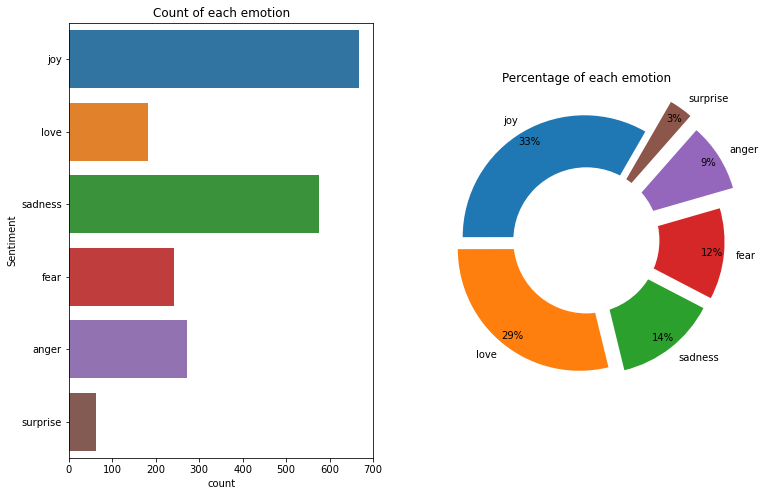

In [13]:
col = 'Sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### Tweet_Emotions

In [23]:
basic_eda(tweet_df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


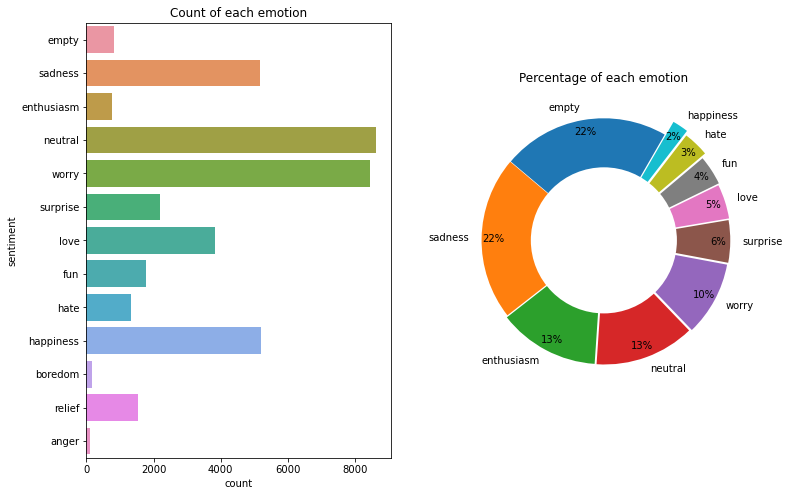

In [24]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

Dataset does not have a balanced amount of datapoints for each class, which will cause the model to not converge. A solution is to remove under-represented classes and combine classes into one class.

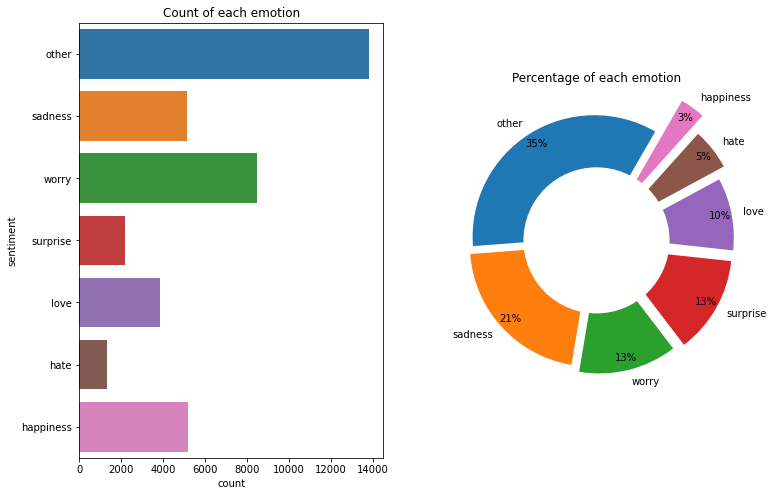

In [45]:
tweet_df['sentiment'] = tweet_df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'surprise', 'love', 'hate'] else "other")
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### GoEmotions Dataset

Robin worked on cleaning up the dataset to be similarly represented as the rest

In [43]:
basic_eda(go_df)

Info : There are 8 columns in the dataset
Info : There are 28427 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 6 numerical columns
Categorical columns :  ['Text', 'ID']
Numerical columns :  ['Unnamed: 0', 'anger', 'fear', 'joy', 'sadness', 'surprise']


,column_name,dtype
0,Unnamed: 0,int64
1,Text,object
2,ID,object
3,anger,int64
4,fear,int64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,Unnamed: 0,28427.0,14213.000000,8206.312387,0.0,7106.5,14213.0,21319.5,28426.0
1,anger,28427.0,0.180005,0.384198,0.0,0.0,0.0,0.0,1.0
2,fear,28427.0,0.024167,0.153571,0.0,0.0,0.0,0.0,1.0
3,joy,28427.0,0.589158,0.491995,0.0,0.0,1.0,1.0,1.0
4,sadness,28427.0,0.108488,0.311002,0.0,0.0,0.0,0.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Text,28427,28301,Thank you.,13
1,ID,28427,28427,eezlygj,1


In [44]:
go_df.head()

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


### Make each dataset categorical

In [58]:
encoded_conn = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 1, 'sadness': 0, 'surprise': 1} 
encoded_anger = {'anger': 1, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_fear = {'anger': 0, 'fear': 1, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_joy = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_love = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 1, 'sadness': 0, 'surprise': 0}
encoded_sadness = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 1, 'surprise': 0}
encoded_surprise = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 1}

tweet_conn = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 1, 'sadness': 0, 'surprise': 1, 'other': 0} 
tweet_anger = {'hate': 1, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_fear = {'hate': 0, 'worry': 1, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_joy = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_love = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 1, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_sadness = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 1, 'surprise': 0, 'other': 0}
tweet_surprise = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 1, 'other': 0}

In [54]:
df['anger'] = df.Sentiment.map(encoded_anger)
df['fear'] = df.Sentiment.map(encoded_fear)
df['joy'] = df.Sentiment.map(encoded_joy)
df['love'] = df.Sentiment.map(encoded_love)
df['sadness'] = df.Sentiment.map(encoded_sadness)
df['surprise'] = df.Sentiment.map(encoded_surprise)
df['connotation'] = df.Sentiment.map(encoded_conn)
df.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
0,7145,i am blank completely i am just feeling every ...,joy,0,0,1,0,0,0,1
1,1458,i feel tender when i have not done anything,love,0,0,0,1,0,0,1
2,11478,i feel like a neglectful pet owner,sadness,0,0,0,0,1,0,0
3,5494,i would not feel as shaken if i were appreciat...,fear,0,1,0,0,0,0,0
4,1647,i was feeling a bit skeptical about my frog pr...,fear,0,1,0,0,0,0,0


In [56]:
tweet_df['anger'] = tweet_df.sentiment.map(tweet_anger)
tweet_df['fear'] = tweet_df.sentiment.map(tweet_fear)
tweet_df['joy'] = tweet_df.sentiment.map(tweet_joy)
tweet_df['love'] = tweet_df.sentiment.map(tweet_love)
tweet_df['sadness'] = tweet_df.sentiment.map(tweet_sadness)
tweet_df['surprise'] = tweet_df.sentiment.map(tweet_surprise)
tweet_df['connotation'] = tweet_df.sentiment.map(tweet_conn)
tweet_df.head()

,tweet_id,sentiment,content,anger,fear,joy,love,sadness,surprise,connotation
0,1956967341,other,@tiffanylue i know i was listenin to bad habi...,0,0,0,0,0,0,0
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,0,0,0,0,1,0,0
2,1956967696,sadness,Funeral ceremony...gloomy friday...,0,0,0,0,1,0,0
3,1956967789,other,wants to hang out with friends SOON!,0,0,0,0,0,0,0
4,1956968416,other,@dannycastillo We want to trade with someone w...,0,0,0,0,0,0,0


## Train-Test Split

In [18]:
# Stratify: Split in a stratified fashion using the class labels, which in this case is under the column header 'Sentiment'
train_data, test_data = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.Sentiment)

In [19]:
#train_data['Label'] = train_data.Sentiment.map(encoded_labels)
#test_data['Label'] = test_data.Sentiment.map(encoded_labels)
train_data.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
677,1068,i wasn t the person who was helping i realized...,joy,0,0,1,0,0,0,1
1217,4728,i won a car in a prizecompetition the moment i...,joy,0,0,1,0,0,0,1
1983,5307,i feed him and how strongly i feel about not f...,sadness,0,0,0,0,1,0,0
940,1854,i dont know why but i am feeling fab u lous today,joy,0,0,1,0,0,0,1
991,1760,i was feeling overwhelmingly anxious so i went...,fear,0,1,0,0,0,0,0


In [20]:
test_data.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
1915,2881,i like to notify that i all the time feel my s...,love,0,0,0,1,0,0,1
1399,1911,i always read but feel hesitant to comment and...,fear,0,1,0,0,0,0,0
1525,1482,i couldn t help feeling curious about what loo...,surprise,0,0,0,0,0,1,1
1576,5897,i have found myself a lot lately i feel discou...,sadness,0,0,0,0,1,0,0
1641,1050,i don t know how i feel about today because pa...,joy,0,0,1,0,0,0,1


## Naive Training by converting text to:
+ Bag of Words: Translates a string to a vector that is the length of number of words in the string, with each index
    representing the number of times a word occurs in a string.
    + Problem: Losses order of words, which is critical for the english language
+ Character Encoding: Encodes the individual characters in a string
    + Problem: Losses concept of words, becomes a very generative approach for our purpose
+ Word Embedding: Transforms each word into number vectors for a given string. The embeddings can be calculated for
    your given dataset, but you could just use pre-computed embeddings.
    + GloVe + word2vec: Embeddings contain a mathematical sense to their numbers by implementing semantic information in the embedding process. For instance, [king] - [man] + [woman] = [queen]

Fixed size vectors means padding needs to be added to the strings to ensure all will be the same length in words

In [36]:
# set parameters:
vocab_size = 500
maxlen = 300
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 128
epochs = 50

In [37]:
# Split to X and Y
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
X_train = train_data['Input']
X_train.head()
Y_train = train_data[labels]
Y_train.head()
X_test = test_data['Input']
Y_test = test_data[labels]
Y_test.head()

Yconn_train = train_data['connotation']
Yconn_test = test_data['connotation']
Yconn_train.head()

677     1
1217    1
1983    0
940     1
991     0
Name: connotation, dtype: int64

In [38]:
# Tokenizer: Ensures inputs that are longer than max vocab size are removed to ensure same size vectors
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [39]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [40]:
embeddings_index = dict()
f = open('glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [41]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [42]:
# Model
model = Sequential()
model.add(Embedding(vocab_size,
                    100,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(128,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          50000     
                                                                 
 dropout_8 (Dropout)         (None, 300, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 300, 128)          38528     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 150, 64)           24640     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 75, 64)           0         
 1D)                                                  

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [44]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

Epoch 1/50
44/44 [==============================] - 6s 96ms/step - loss: 1.6504 - accuracy: 0.3086 - val_loss: 1.6376 - val_accuracy: 0.3383
Epoch 2/50
44/44 [==============================] - 4s 82ms/step - loss: 1.6098 - accuracy: 0.3300 - val_loss: 1.6339 - val_accuracy: 0.3100
Epoch 3/50
44/44 [==============================] - 4s 80ms/step - loss: 1.5946 - accuracy: 0.3186 - val_loss: 1.6246 - val_accuracy: 0.3100
Epoch 4/50
44/44 [==============================] - 4s 85ms/step - loss: 1.5864 - accuracy: 0.3129 - val_loss: 1.5958 - val_accuracy: 0.3383
Epoch 5/50
 2/44 [>.............................] - ETA: 3s - loss: 1.5372 - accuracy: 0.3594

KeyboardInterrupt: 

In [45]:
#@tab pytorch
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [46]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

NameError: name 'd2l' is not defined